In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from random import randint
import cv2 
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.datasets import mnist

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 800)

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")

Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)
X_train.shape, Y_train.shape

((42000, 784), (42000,))

In [3]:
(x_train1, y_train1), (test, y_test) = mnist.load_data()

Y_train1 = y_train1
X_train1 = x_train1.reshape(-1, 28*28)
X_train1.shape, Y_train1.shape

((60000, 784), (60000,))

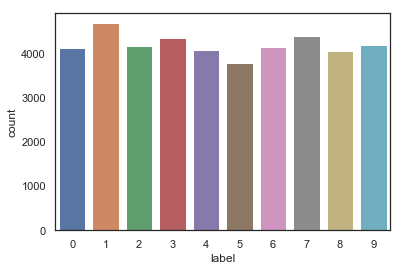

In [4]:
sns.countplot(Y_train)

In [5]:
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

In [6]:
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))
X_train.shape, Y_train.shape

((102000, 784), (102000,))

In [7]:
X_train = X_train.reshape(-1,28,28)
test = test.reshape(-1,28,28)
X_train.shape, test.shape

((102000, 28, 28), (10000, 28, 28))

In [8]:
X_train2 = X_train.copy()
test2 = test.copy()
X_train2.shape, test2.shape

((102000, 28, 28), (10000, 28, 28))

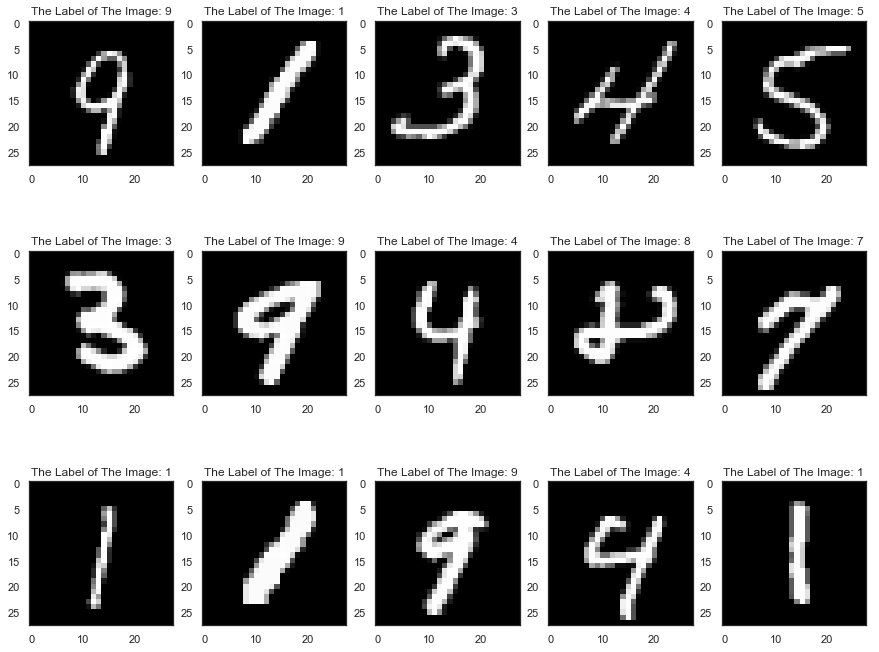

In [9]:
img = [randint(0, X_train.shape[0]) for p in range(0, 15)]
plt.figure(figsize=(15,12))
for image_index in range(0,15):
    plt.subplot(3, 5, image_index+1)
    plt.imshow(np.squeeze(X_train[img[image_index]]), cmap=plt.get_cmap('gray'))
    plt.title("The Label of The Image: %i" %Y_train[img[image_index]])
plt.show()

## Erosion

In [10]:
for img in range(X_train.shape[0]):
    X_train[img] = cv2.erode(np.squeeze(X_train2[img]), (3, 3))
print("Erosion of the training dataset was done!")

for img in range(test.shape[0]):
    test[img] = cv2.erode(np.squeeze(test2[img]), (3, 3))
print("Erosion of the test dataset was done!")

Erosion of the training dataset was done!
Erosion of the test dataset was done!


In [11]:
X_train = X_train.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)
X_train.shape, test.shape

((102000, 28, 28, 1), (10000, 28, 28, 1))

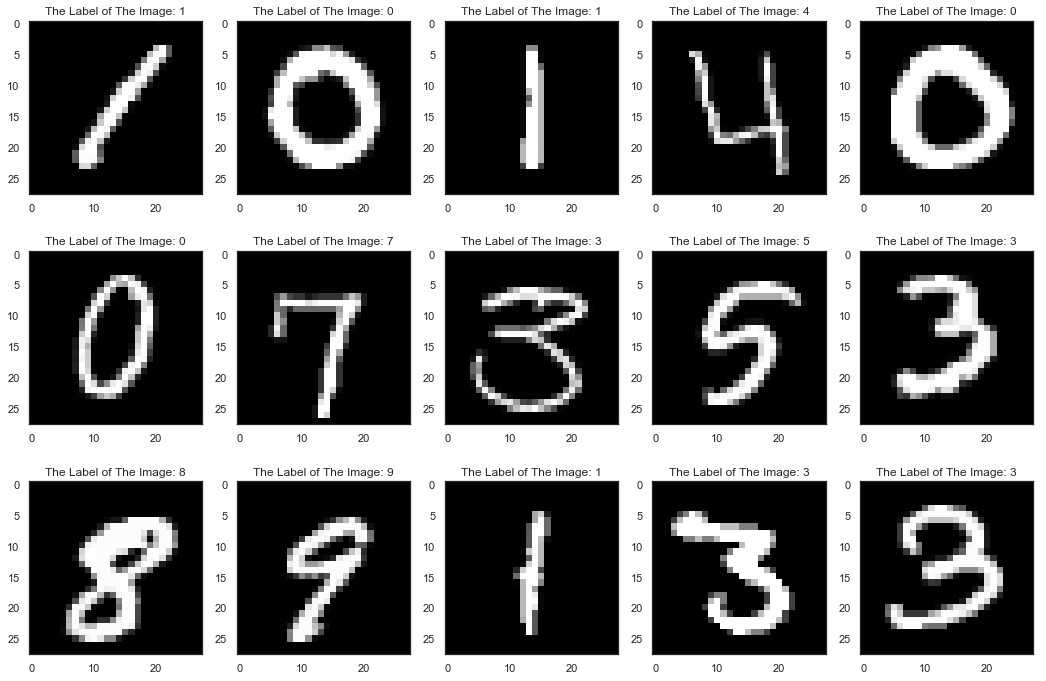

In [12]:
plt.figure(figsize=(18,12))
for i in range(0,15):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.squeeze(X_train2[i]), cmap=plt.get_cmap('gray'))
    plt.title("The Label of The Image: %i" %Y_train[i])
plt.show()

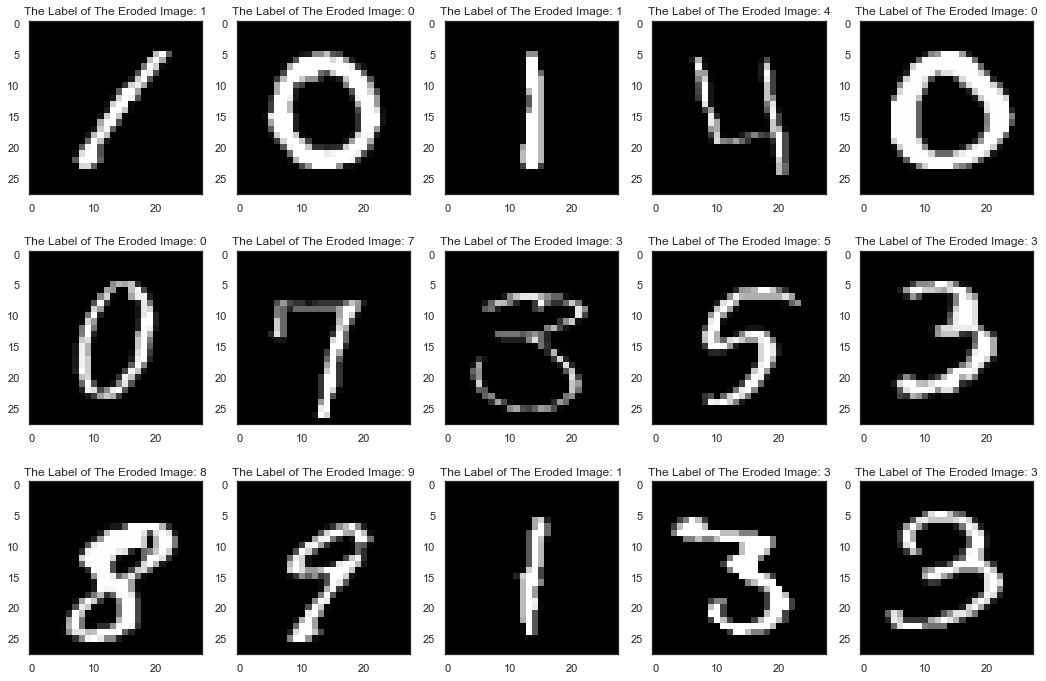

In [13]:
plt.figure(figsize=(18,12))
for i in range(0,15):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.squeeze(X_train[i]), cmap=plt.get_cmap('gray'))
    plt.title("The Label of The Eroded Image: %i" %Y_train[i])
plt.show()

In [14]:
Y_train = to_categorical(Y_train, num_classes = 10) # (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train.shape

(102000, 10)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.33, random_state=2019)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((68340, 28, 28, 1), (33660, 28, 28, 1), (68340, 10), (33660, 10))

In [16]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
epochs = 50
batch_size = 64

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)
test_gen = datagen.flow(X_val, Y_val, batch_size=batch_size)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('mnist_CNN_eroded_batch_size_64.h5', verbose=1, save_best_only=True)
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_val.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction, early_stopping, model_checkpoint])

Epoch 1/50
1067/1067 [==============================] - 87s 81ms/step - loss: 0.1820 - accuracy: 0.9435 - val_loss: 0.0331 - val_accuracy: 0.9637

Epoch 00001: val_loss improved from inf to 0.03309, saving model to mnist_CNN_eroded_batch_size_64.h5
Epoch 2/50
1067/1067 [==============================] - 84s 79ms/step - loss: 0.0674 - accuracy: 0.9797 - val_loss: 0.0923 - val_accuracy: 0.9806

Epoch 00002: val_loss did not improve from 0.03309
Epoch 3/50
1067/1067 [==============================] - 84s 78ms/step - loss: 0.0505 - accuracy: 0.9843 - val_loss: 0.0706 - val_accuracy: 0.9876

Epoch 00003: val_loss did not improve from 0.03309
Epoch 4/50
1067/1067 [==============================] - 84s 78ms/step - loss: 0.0424 - accuracy: 0.9870 - val_loss: 0.0023 - val_accuracy: 0.9899

Epoch 00004: val_loss improved from 0.03309 to 0.00231, saving model to mnist_CNN_eroded_batch_size_64.h5
Epoch 5/50
1067/1067 [==============================] - 84s 78ms/step - loss: 0.0385 - accuracy: 0.988

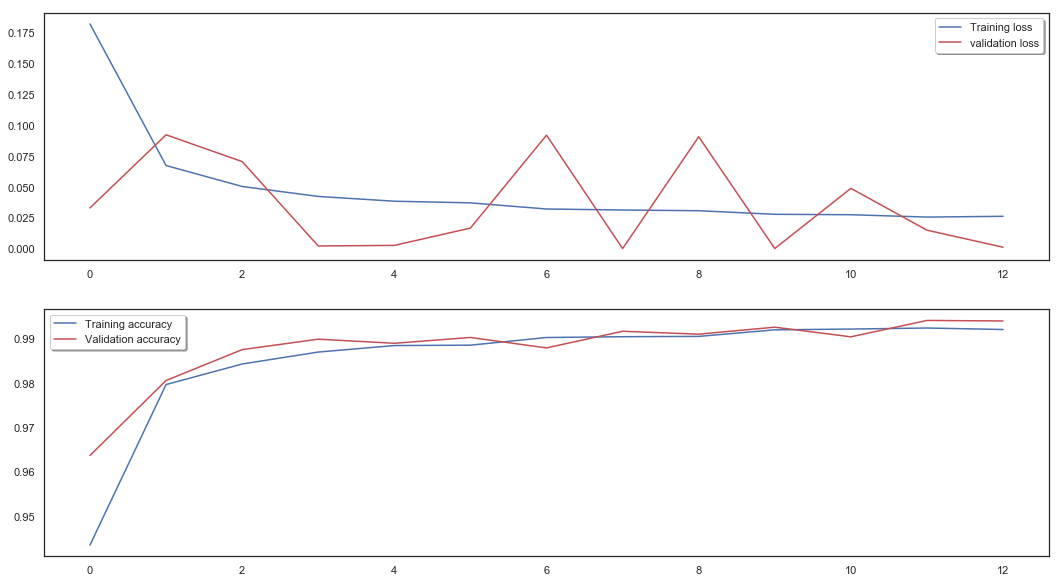

In [21]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(18,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

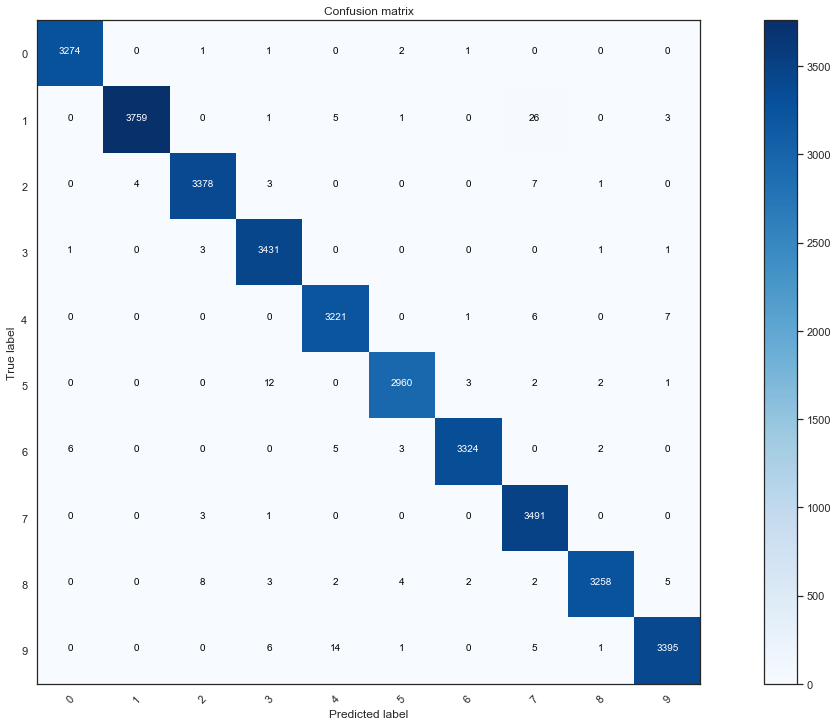

In [23]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [24]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3279
           1       1.00      0.99      0.99      3795
           2       1.00      1.00      1.00      3393
           3       0.99      1.00      1.00      3437
           4       0.99      1.00      0.99      3235
           5       1.00      0.99      0.99      2980
           6       1.00      1.00      1.00      3340
           7       0.99      1.00      0.99      3495
           8       1.00      0.99      0.99      3284
           9       1.00      0.99      0.99      3422

   micro avg       0.99      0.99      0.99     33660
   macro avg       1.00      1.00      0.99     33660
weighted avg       0.99      0.99      0.99     33660



In [25]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [26]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 15 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(15,12))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.get_cmap('gray'))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

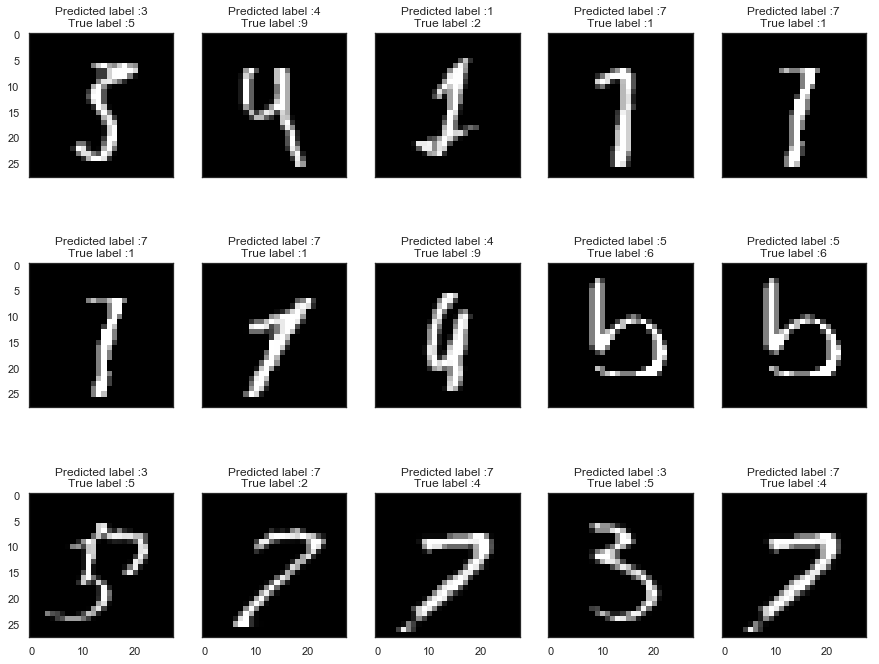

In [27]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 15 errors 
most_important_errors = sorted_dela_errors[-15:]

# Show the top 15 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Test Data Confusion Matrix

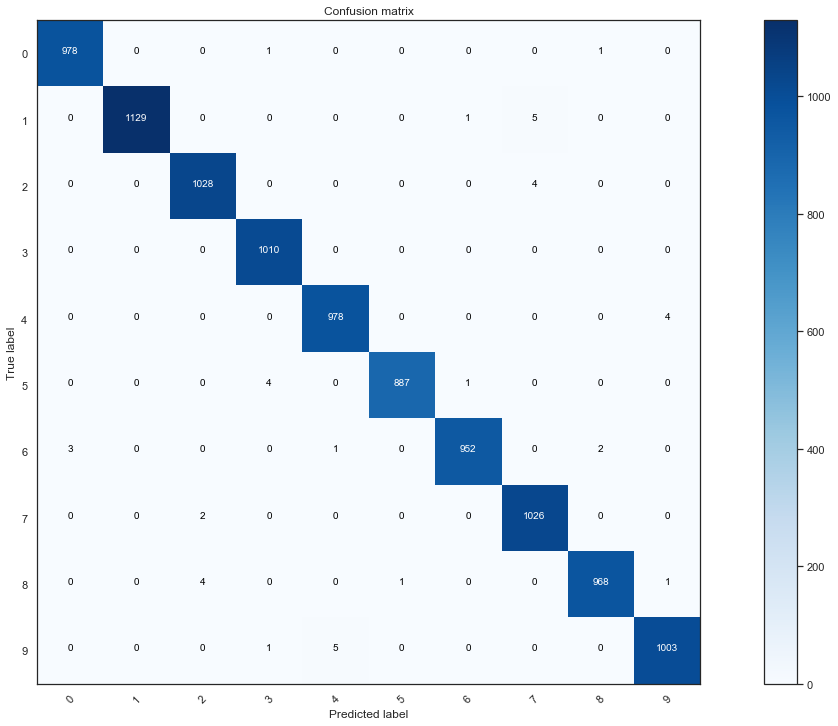

In [28]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
confusion_mtx = confusion_matrix(y_test, results)
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [29]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

